In [1]:
import os
import simpy as sim
import numpy as np
import pandas as pd

from open_pharma_twin.factory.plants import biomanufacturing_plant
from open_pharma_twin.factory.processing_unit import UpstreamUnit
from open_pharma_twin.factory.equipment_module import Vessel
from open_pharma_twin.simulation import run_campaign_on_factory, Monitor


In [2]:
# Process Modell
def campaignA_upstream_generateMedium():
    pass


def campaignA_cip(env, vessel):
    yield env.process(vessel.produce(incubation_time=30))


def campaignA_upstream(env, runID, plant, monitor):
    product = "Bruehe"

    #Stage 1
    ## Init
    active_vessel_stage1 = plant.ferm_stage1.get_vessel()
    yield active_vessel_stage1.activate_resource()
    monitor.record_campaign(runID, "Start")
    monitor.record_process(campaignID=runID, process=product, action="Campaign Start")
    monitor.record_vessel(campaignID=runID, vessel=active_vessel_stage1, action="allocation_start")
    active_vessel_stage1.fill(60)

    ## prod1
    monitor.record_vessel(campaignID=runID, vessel=active_vessel_stage1, action="prod_start")
    yield env.process(active_vessel_stage1.produce(incubation_time=30))
    monitor.record_vessel(campaignID=runID, vessel=active_vessel_stage1, action="prod_end")


    #Stage 2
    active_vessel_stage2 = plant.ferm_stage2.get_vessel()
    yield active_vessel_stage2.activate_resource()
    active_vessel_stage1.transfer(active_vessel_stage2, dv=60)
    yield env.process(campaignA_cip(env, active_vessel_stage1))
    active_vessel_stage1.release_resource()
    monitor.record_process(campaignID=runID, process=product, action="Stage1 Done")
    monitor.record_vessel(campaignID=runID, vessel=active_vessel_stage1, action="allocation_end")
    monitor.record_vessel(campaignID=runID, vessel=active_vessel_stage2, action="allocation_start")

    monitor.record_vessel(campaignID=runID, vessel=active_vessel_stage2, action="prod_start")
    yield env.process(active_vessel_stage2.produce(40))
    monitor.record_vessel(campaignID=runID, vessel=active_vessel_stage2, action="prod_end")


    #Stage 3
    active_vessel_stage3 = plant.ferm_stage3.get_vessel()
    yield active_vessel_stage3.activate_resource()
    active_vessel_stage2.transfer(active_vessel_stage3)
    active_vessel_stage2.release_resource()
    monitor.record_vessel(campaignID=runID, vessel=active_vessel_stage2, action="allocation_end")
    monitor.record_vessel(campaignID=runID, vessel=active_vessel_stage3, action="allocation_start")
    monitor.record_process(campaignID=runID, process=product, action="Stage2 Done")

    monitor.record_vessel(campaignID=runID, vessel=active_vessel_stage3, action="production_start")
    yield env.process(active_vessel_stage3.produce(80))
    monitor.record_vessel(campaignID=runID, vessel=active_vessel_stage3, action="production_end")


    #Stage 4
    active_vessel_stage4 = plant.ferm_stage4.get_vessel()
    yield active_vessel_stage4.activate_resource()
    active_vessel_stage3.transfer(active_vessel_stage4)
    active_vessel_stage3.release_resource()
    monitor.record_vessel(campaignID=runID, vessel=active_vessel_stage4, action="allocation_start")
    monitor.record_vessel(campaignID=runID, vessel=active_vessel_stage3, action="allocation_end")
    monitor.record_process(campaignID=runID, process=product, action="Stage3 Done")

    monitor.record_vessel(campaignID=runID, vessel=active_vessel_stage4, action="prod_start")
    yield env.process(active_vessel_stage4.produce(100))
    monitor.record_vessel(campaignID=runID, vessel=active_vessel_stage4, action="prod_end")

    #Harvest
    active_harvester = plant.harvester.get_vessel()
    yield active_harvester.activate_resource()
    active_vessel_stage4.transfer(active_harvester)
    active_vessel_stage4.release_resource()
    monitor.record_vessel(campaignID=runID, vessel=active_harvester, action="allocation_start")
    monitor.record_vessel(campaignID=runID, vessel=active_vessel_stage4, action="allocation_end")
    monitor.record_process(campaignID=runID, process=product, action="Stage4 Done")

    monitor.record_vessel(campaignID=runID, vessel=active_harvester, action="production_start")
    yield env.process(active_harvester.produce(30))
    monitor.record_vessel(campaignID=runID, vessel=active_harvester, action="production_end")

    active_harvester.remove()
    active_harvester.release_resource()
    monitor.record_vessel(campaignID=runID, vessel=active_harvester, action="allocation_end")
    monitor.record_process(campaignID=runID, process=product, action="Harvester Done")
    monitor.record_process(campaignID=runID, process=product, action="Campaign Done")

    # Post Analysis
    monitor.record_campaign(runID, "End")

def campaignA(env, runID, plant:biomanufacturing_plant, monitor): # Process Control
    yield env.process(campaignA_upstream(env, runID, plant.upstream, monitor))



In [3]:
# Run simulation:
monitors = []
for i in range(1,6):
    print(i)
    env = sim.Environment()
    monitor = Monitor(env=env)
    # Plant Modell
    upstream_unit = UpstreamUnit(env=env,
                    num_ferm_stage1=6, num_ferm_stage2=i, num_ferm_stage3=i, num_ferm_stage4=i*2,
                    num_harvester=2)
    plant = biomanufacturing_plant(upstream=upstream_unit)

    # Simulation
    simulation = run_campaign_on_factory(env=env, campaign=campaignA,
                                         plant=plant, monitor=monitor, num_runs=20)
    env.process(simulation)
    env.run()

    # Results
    monitor.num_stage2= i
    monitors.append(monitor)


1
2
3
4
5


In [4]:
# Simulation Tools
monitor = monitors[-1]
df_product = monitor.process_monitor
df_equippment = monitor.equippment_monitor
df_ressource = monitor.ressource_monitor
df_equippment

,name,Campaign_ID,time,level,action
0,Vessel_S1,0,0,0,allocation_start
1,Vessel_S1,0,0,60,prod_start
2,Vessel_S1,1,0,0,allocation_start
3,Vessel_S1,1,0,60,prod_start
4,Vessel_S1,2,0,0,allocation_start
...,...,...,...,...,...
395,harvester,19,580,60,production_start
396,harvester,18,590,60,production_end
397,harvester,18,590,0,allocation_end
398,harvester,19,610,60,production_end


/tmp/ipykernel_3327/3709598832.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  start_t = float(sub_df.loc[sub_df["action"]=="allocation_start", "time"])
/tmp/ipykernel_3327/3709598832.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  end_t = float(sub_df.loc[sub_df["action"]=="allocation_end", "time"])


(0.0, 250.0)

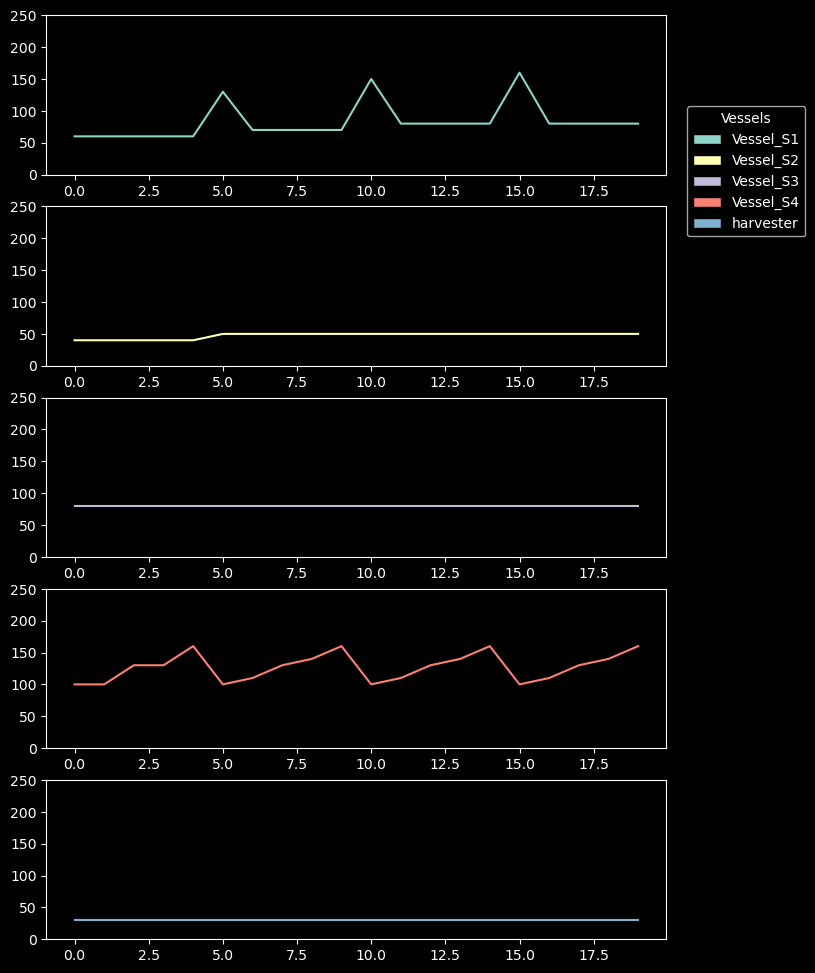

In [15]:
# Process duration in Equipment
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

#aggregate data
df_equippment = monitor.equippment_monitor
usage = []
durations = []
for campaignID in df_equippment["Campaign_ID"].unique():
    ddf = df_equippment.loc[df_equippment["Campaign_ID"] == campaignID]

    for vessel in ddf["name"].unique():
        sub_df = ddf.loc[ddf["name"] == vessel]

        start_t = float(sub_df.loc[sub_df["action"]=="allocation_start", "time"])
        end_t = float(sub_df.loc[sub_df["action"]=="allocation_end", "time"])
        duration = end_t - start_t

        usage.append((vessel, start_t, end_t, int(campaignID)))
        durations.append((vessel, campaignID, duration))
df = pd.DataFrame(durations, columns=["vessel", "campaign", "duration"])
vessel_names =list(df["vessel"].unique())

#Plot
fig, axs = plt.subplots(nrows=len(vessel_names), sharey=True, figsize=(8, 12))
i=0
leg = []
for ax, vessel in zip(axs, sorted(vessel_names, key=lambda x: x[-1])):
    sdf = df.loc[df["vessel"] == vessel]
    ax.plot(sdf["campaign"], sdf["duration"],label=vessel, c=f"C{i}")
    leg.append((i, vessel))
    i+=1

legend_handles = [Patch(facecolor=f"C{i}", edgecolor="black", label=name)
                  for i, name in leg]
fig.legend(handles=legend_handles, title="Vessels", bbox_to_anchor=(1, 0.75), loc="center")
ax.set_ylim([0,250])

0 Vessel_S1 0.0 60.0
0 Vessel_S2 60.0 40.0
0 Vessel_S3 100.0 80.0
0 Vessel_S4 180.0 100.0
0 harvester 280.0 30.0
1 Vessel_S1 0.0 60.0
1 Vessel_S2 60.0 40.0
1 Vessel_S3 100.0 80.0
1 Vessel_S4 180.0 100.0
1 harvester 280.0 30.0
2 Vessel_S1 0.0 60.0
2 Vessel_S2 60.0 40.0
2 Vessel_S3 100.0 80.0
2 Vessel_S4 180.0 130.0
2 harvester 310.0 30.0
3 Vessel_S1 0.0 60.0
3 Vessel_S2 60.0 40.0
3 Vessel_S3 100.0 80.0
3 Vessel_S4 180.0 130.0
3 harvester 310.0 30.0
4 Vessel_S1 0.0 60.0
4 Vessel_S2 60.0 40.0
4 Vessel_S3 100.0 80.0
4 Vessel_S4 180.0 160.0
4 harvester 340.0 30.0
5 Vessel_S1 0.0 130.0
5 Vessel_S2 130.0 50.0
5 Vessel_S3 180.0 80.0
5 Vessel_S4 260.0 100.0
5 harvester 360.0 30.0
6 Vessel_S1 60.0 70.0
6 Vessel_S2 130.0 50.0
6 Vessel_S3 180.0 80.0
6 Vessel_S4 260.0 110.0
6 harvester 370.0 30.0
7 Vessel_S1 60.0 70.0
7 Vessel_S2 130.0 50.0
7 Vessel_S3 180.0 80.0
7 Vessel_S4 260.0 130.0
7 harvester 390.0 30.0
8 Vessel_S1 60.0 70.0
8 Vessel_S2 130.0 50.0
8 Vessel_S3 180.0 80.0
8 Vessel_S4 260.0 140.

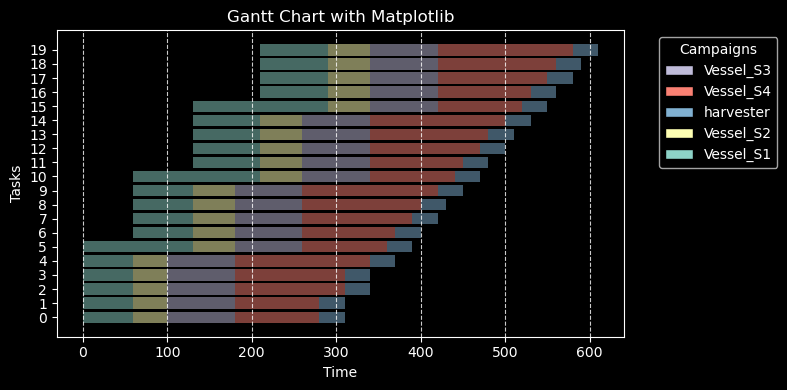

In [8]:
# gant chart of process

import matplotlib.pyplot as plt
from matplotlib.patches import Patch

start_r = 2
stop = 6
# Sample task data: (Task Name, Start Date, End Date)
tasks = usage

# Prepare data for plotting
fig, ax = plt.subplots(figsize=(8, 4))

tasksz = list(df_equippment["name"].unique())
yticklabels = list(df_equippment["Campaign_ID"].unique())
yticks = list(range(len(yticklabels)))

cids = []
for i, (task, start, end, campaign) in enumerate(tasks):

    cids.append(task)
    start_num = start
    end_num = end
    duration = end_num - start_num
    print(campaign, task, start, duration)

    # Plot the task as a horizontal bar
    ax.broken_barh([(start_num, duration)], (yticklabels.index(campaign) - 0.4, 0.8), facecolors=f"C{tasksz.index(task)}", alpha=0.5)

# Configure Y-axis
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels)

# Labels and title
ax.set_xlabel("Time")
ax.set_ylabel("Tasks")
ax.set_title("Gantt Chart with Matplotlib")

# Grid for better readability
ax.grid(True, axis="x", linestyle="--", alpha=0.8)

# Create legend from phase_colors
legend_handles = [Patch(facecolor=f"C{tasksz.index(cid)}", edgecolor="black", label=cid)
                  for cid in set(cids)]
ax.legend(handles=legend_handles, title="Campaigns", bbox_to_anchor=(1.05, 1), loc="upper left")


plt.tight_layout()
plt.show()


In [ ]:
#Changes in Plant Layout:

from matplotlib import pyplot as plt


for j, monitor in enumerate(monitors):
    print(j)
    durations=[]
    df_active_campaign = monitor.campaign_monitor
    for i in df_active_campaign["name"].unique():
        sub_df = df_active_campaign.loc[df_active_campaign["name"] == i]
        duration = float(sub_df.loc[sub_df["action"]=="End", "time"]) - float(sub_df.loc[sub_df["action"]=="Start", "time"])
        durations.append(duration)
    plt.plot(durations, alpha=0.5, label=monitor.num_stage2, c=f"C{j+1}")

plt.legend(title="number of fermenter stage 2")
plt.ylabel("Durations")
plt.xlabel("Run")

In [9]:
#Graph Layout of plant & process
# To be coded
import networkx as nx

def to_graph(self):
    g = nx.Graph()
    g.add_node(self, name=self.name, degree=2-self.lever)
    ln=self
    for n in self.sub_compartments:
        g.add_node(n, name=n.name, degree=2-n.lever)
        g.add_edge(ln, n)
        ln=n

    lc = None
    for c in p.sub_compartments:
        g.add_edge(c, c.sub_compartments[0], type=0)
        for c2 in c.sub_compartments:
            g.add_node(c2, name=c2.name, degree=2-c2.lever)
            if lc is not None:
                g.add_edge(lc, c2, type=1)
            lc = c2
    return g
